In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering

In [2]:
def format_axes(ax):
    sns.despine()
    ax.spines['left'].set_color('#ddd')
    ax.spines['bottom'].set_color('#ddd')

    ax.yaxis.grid(True, color='#eee')
    ax.xaxis.grid(True, color='#eee')

In [3]:
df_orig = pd.read_csv('cluster_df.csv')
df_orig.shape

(2212, 6)

In [4]:
df_orig.head()

,AgeRange,Education,Rel_Status,Income,Minorhome,TotalSpend
0,50+,Graduation,Single,58138.0,0,1617
1,50+,Graduation,Single,46344.0,2,27
2,35-50,Graduation,Coupled,71613.0,0,776
3,<35,Graduation,Coupled,26646.0,1,53
4,<35,PhD,Coupled,58293.0,1,422


In [5]:
df_orig['Minorhome'] = df_orig['Minorhome'].replace(to_replace=[0, [1, 2, 3]], value=['No', 'Yes'])
df_orig.head(10)

,AgeRange,Education,Rel_Status,Income,Minorhome,TotalSpend
0,50+,Graduation,Single,58138.0,No,1617
1,50+,Graduation,Single,46344.0,Yes,27
2,35-50,Graduation,Coupled,71613.0,No,776
3,<35,Graduation,Coupled,26646.0,Yes,53
4,<35,PhD,Coupled,58293.0,Yes,422
5,35-50,Master,Coupled,62513.0,Yes,716
6,35-50,Graduation,Single,55635.0,Yes,590
7,<35,PhD,Coupled,33454.0,Yes,169
8,35-50,PhD,Coupled,30351.0,Yes,46
9,50+,PhD,Coupled,5648.0,Yes,49


In [6]:
df = df_orig.copy()

In [7]:
col_name_dict = {'AgeRange':'Age', 'Education':'Ed', 'Rel_Status':'Rel'}
df = df.rename(columns=col_name_dict)
df.head()

,Age,Ed,Rel,Income,Minorhome,TotalSpend
0,50+,Graduation,Single,58138.0,No,1617
1,50+,Graduation,Single,46344.0,Yes,27
2,35-50,Graduation,Coupled,71613.0,No,776
3,<35,Graduation,Coupled,26646.0,Yes,53
4,<35,PhD,Coupled,58293.0,Yes,422


In [8]:
def encode_and_bind(dataframe, features):
    dummies = pd.get_dummies(dataframe[features])
    res = pd.concat([dummies, dataframe], axis=1)
    res = res.drop(columns=features) 
    return(res) 

In [9]:
df = encode_and_bind(dataframe=df, features=['Minorhome', 'Age', 'Ed', 'Rel'])
df.head()

,Minorhome_No,Minorhome_Yes,Age_35-50,Age_50+,Age_<35,Ed_2n Cycle,Ed_Basic,Ed_Graduation,Ed_Master,Ed_PhD,Rel_Coupled,Rel_Single,Income,TotalSpend
0,1,0,0,1,0,0,0,1,0,0,0,1,58138.0,1617
1,0,1,0,1,0,0,0,1,0,0,0,1,46344.0,27
2,1,0,1,0,0,0,0,1,0,0,1,0,71613.0,776
3,0,1,0,0,1,0,0,1,0,0,1,0,26646.0,53
4,0,1,0,0,1,0,0,0,0,1,1,0,58293.0,422


In [10]:
df = df.drop(['Rel_Coupled', 'Ed_Graduation', 'Age_35-50', 'Minorhome_Yes'], axis=1)
df.head()

,Minorhome_No,Age_50+,Age_<35,Ed_2n Cycle,Ed_Basic,Ed_Master,Ed_PhD,Rel_Single,Income,TotalSpend
0,1,1,0,0,0,0,0,1,58138.0,1617
1,0,1,0,0,0,0,0,1,46344.0,27
2,1,0,0,0,0,0,0,0,71613.0,776
3,0,0,1,0,0,0,0,0,26646.0,53
4,0,0,1,0,0,0,1,0,58293.0,422


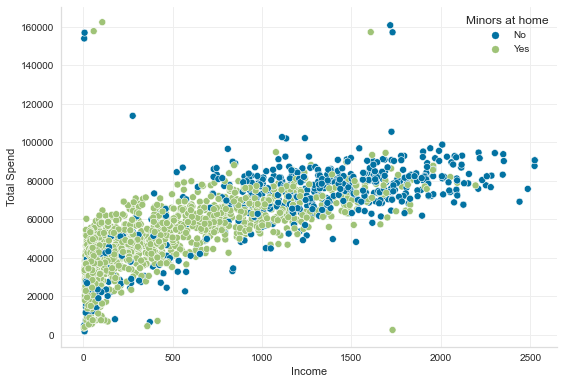

In [11]:
ax = sns.scatterplot(data=df_orig, y='Income', x='TotalSpend', hue='Minorhome')
format_axes(ax)
plt.xlabel('Income')
plt.ylabel('Total Spend')
plt.legend(title='Minors at home')
plt.tight_layout()
plt.show()

In [12]:
scaler = StandardScaler()
df[df.columns[8:]] = scaler.fit_transform(df[df.columns[8:]])
df.head()

,Minorhome_No,Age_50+,Age_<35,Ed_2n Cycle,Ed_Basic,Ed_Master,Ed_PhD,Rel_Single,Income,TotalSpend
0,1,1,0,0,0,0,0,1,0.287105,1.676245
1,0,1,0,0,0,0,0,1,-0.260882,-0.963297
2,1,0,0,0,0,0,0,0,0.913196,0.280110
3,0,0,1,0,0,0,0,0,-1.176114,-0.920135
4,0,0,1,0,0,0,1,0,0.294307,-0.307562


# Scree Plot for PCA

In [13]:
pca = PCA()
pca.fit(df)
pca_data = pca.transform(df)

In [14]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=2)
per_var

array([57.22,  9.21,  7.14,  6.4 ,  5.82,  4.52,  3.67,  3.22,  2.14,
        0.66])

In [15]:
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

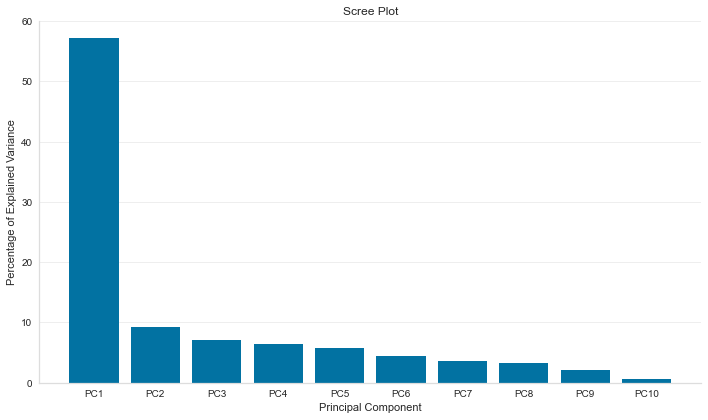

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
format_axes(ax)
ax.xaxis.grid(False)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.title('Scree Plot')
plt.tight_layout()
plt.show()

In [17]:
pca_df = pd.DataFrame(pca_data, columns=labels)

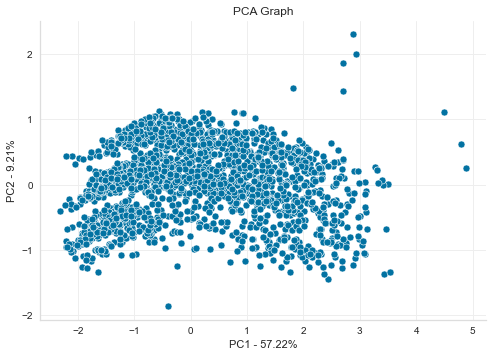

In [18]:
ax = sns.scatterplot(x=pca_df.PC1, y=pca_df.PC2)
format_axes(ax)
plt.xlabel(f'PC1 - {per_var[0]}%')
plt.ylabel(f'PC2 - {per_var[1]}%')
plt.title('PCA Graph')
plt.show()

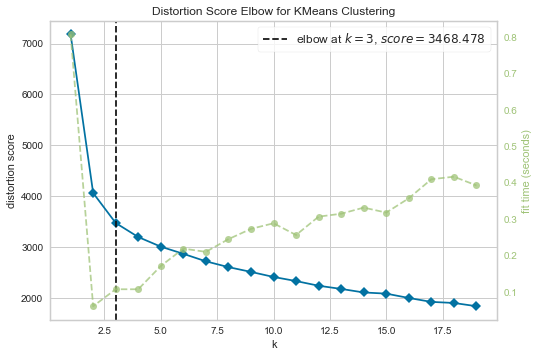

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
model = KMeans()
visualizer = KElbowVisualizer(estimator=model, k=(1,20), metric='distortion')
visualizer.fit(df)
visualizer.show()

In [20]:
num_clusters = 3

In [21]:
ac = AgglomerativeClustering(n_clusters=num_clusters)
ac_df = ac.fit_predict(df) + 1
df['Cluster'] = ac_df
df_orig['Cluster'] = ac_df
df_orig['Cluster'] = df_orig['Cluster'].astype('category')
df_orig.head()

,AgeRange,Education,Rel_Status,Income,Minorhome,TotalSpend,Cluster
0,50+,Graduation,Single,58138.0,No,1617,2
1,50+,Graduation,Single,46344.0,Yes,27,1
2,35-50,Graduation,Coupled,71613.0,No,776,2
3,<35,Graduation,Coupled,26646.0,Yes,53,1
4,<35,PhD,Coupled,58293.0,Yes,422,3


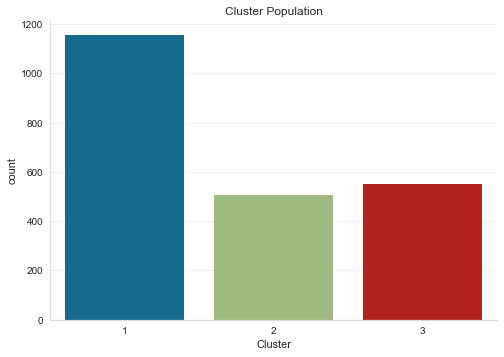

In [22]:
cplot = sns.countplot(x=df['Cluster'])
cplot.set_title('Cluster Population')
format_axes(cplot)
cplot.xaxis.grid(False)
plt.show()

## Split cluster subplots

In [23]:
cluster_dfs = list(map(lambda x: df_orig[df_orig['Cluster']==x], range(1, num_clusters+1)))

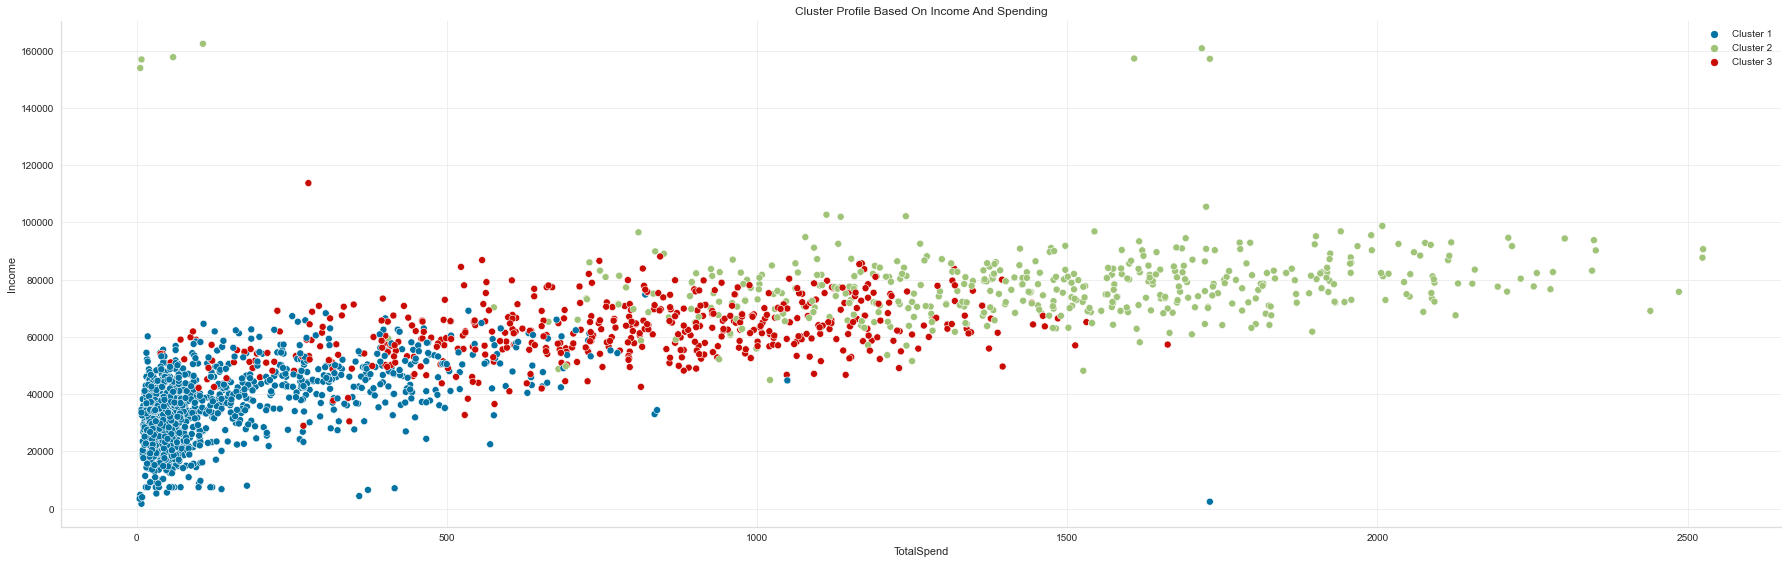

In [24]:
fig, ax = plt.subplots(figsize=(25,8))
sns.scatterplot(data=df_orig, x='TotalSpend', y='Income', hue='Cluster', ax=ax)
format_axes(ax)
plt.title("Cluster Profile Based On Income And Spending")
handles, labels = ax.get_legend_handles_labels()
labels = [f'Cluster {x+1}' for x in range(num_clusters)]
ax.legend(handles, labels)
plt.tight_layout()
plt.show()

In [25]:
def plot_cluster_profile(column, color_palette, legend_title):
    fig, axs = plt.subplots(nrows=1, ncols=num_clusters, sharex='all', sharey='all', figsize=(25,7))

    for i in range(num_clusters):
        plt.subplot(1, num_clusters, i+1)
        ax = sns.scatterplot(data=cluster_dfs[i], x='TotalSpend', y='Income', hue=column, palette=color_palette)
        format_axes(ax)

        plt.title(f'Cluster {i+1}')
        plt.plot()

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.01), ncol=df_orig[column].nunique(), title=legend_title, borderpad=1, labelspacing=1.05)
    [p.get_legend().remove() for p in axs]
    plt.suptitle(f'Cluster Profile Based on {legend_title} (Income vs Spending)')
    fig.tight_layout()
    plt.show()

In [26]:
minor_palette = {'Yes':'tab:blue', 'No':'#e33636'}
age_palette = {'<35':'tab:blue', '35-50':'#99d45f', '50+':'#e33636'}
education_palette = {'PhD':'#e377c2', 'Master':'#bcbd22', 'Graduation':'#17becf', 'Basic':'#7f7f7f', '2n Cycle':'#963F89'}

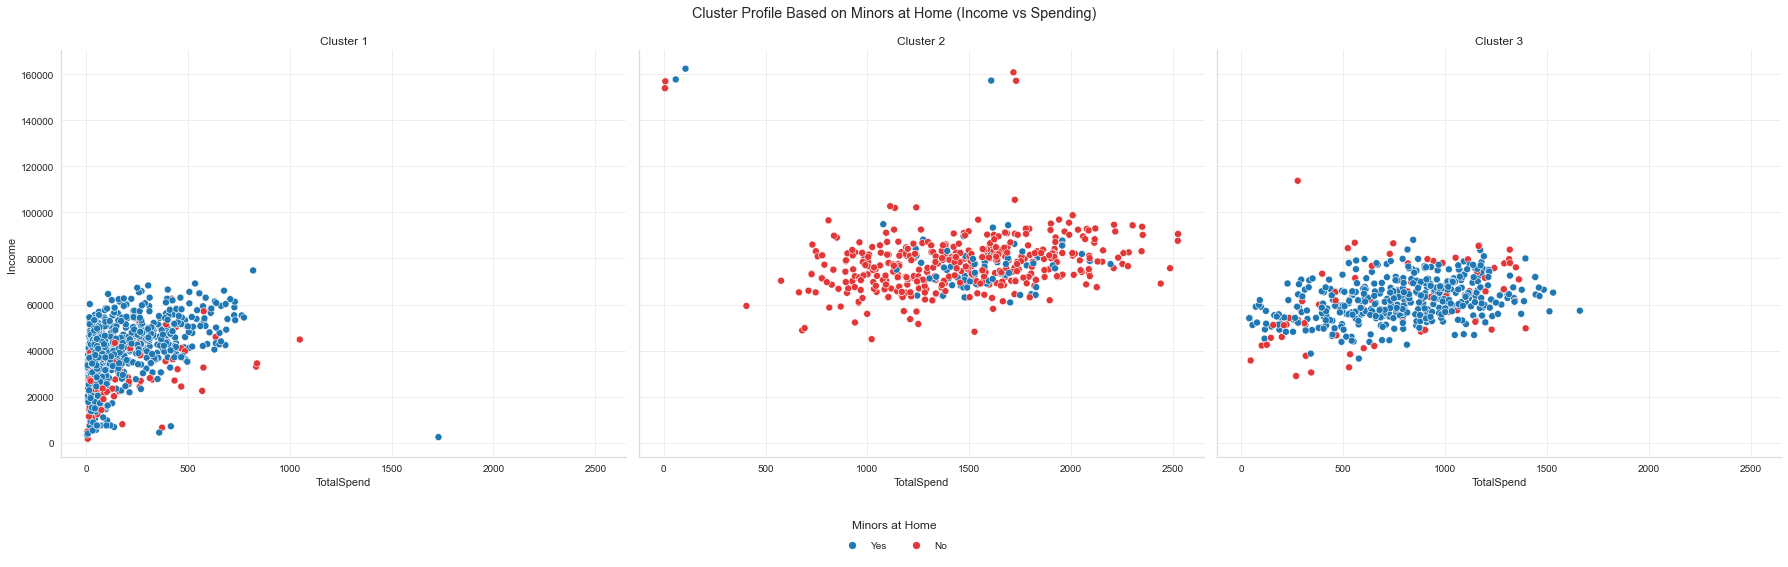

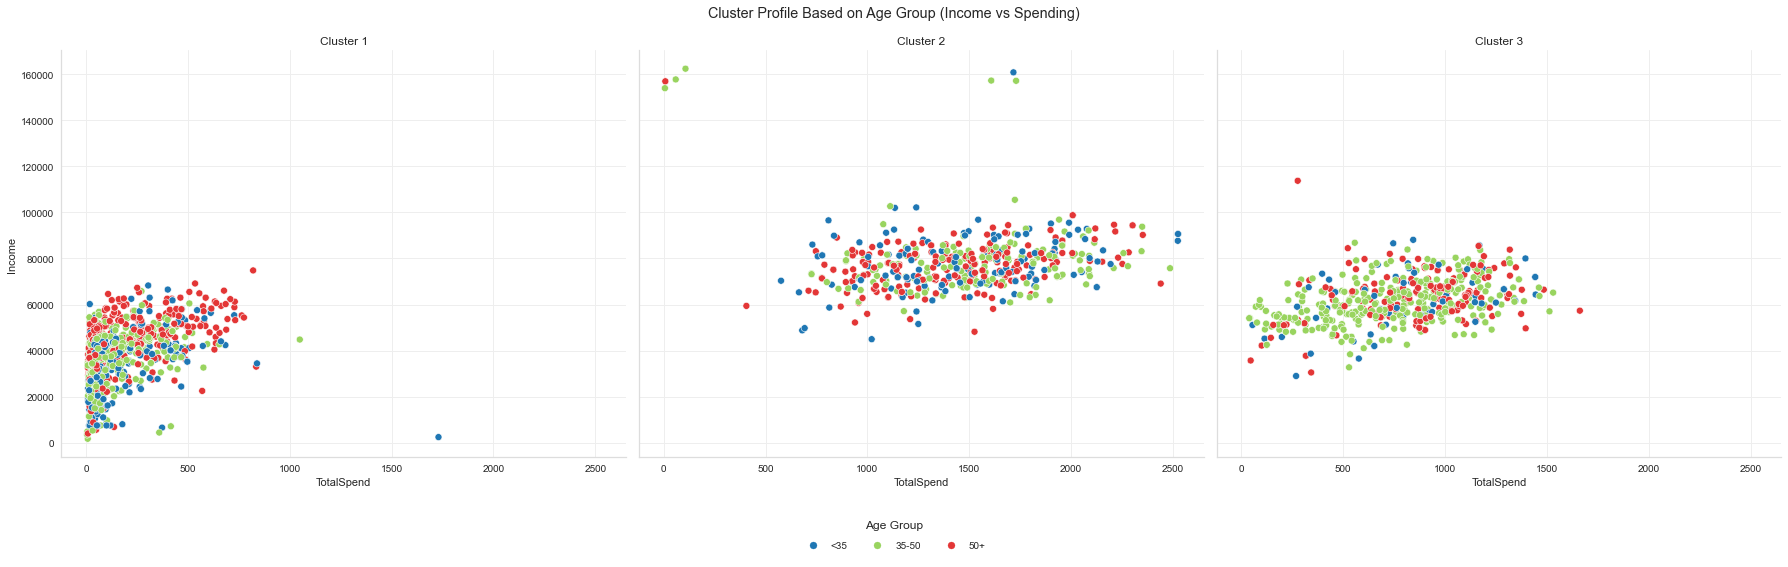

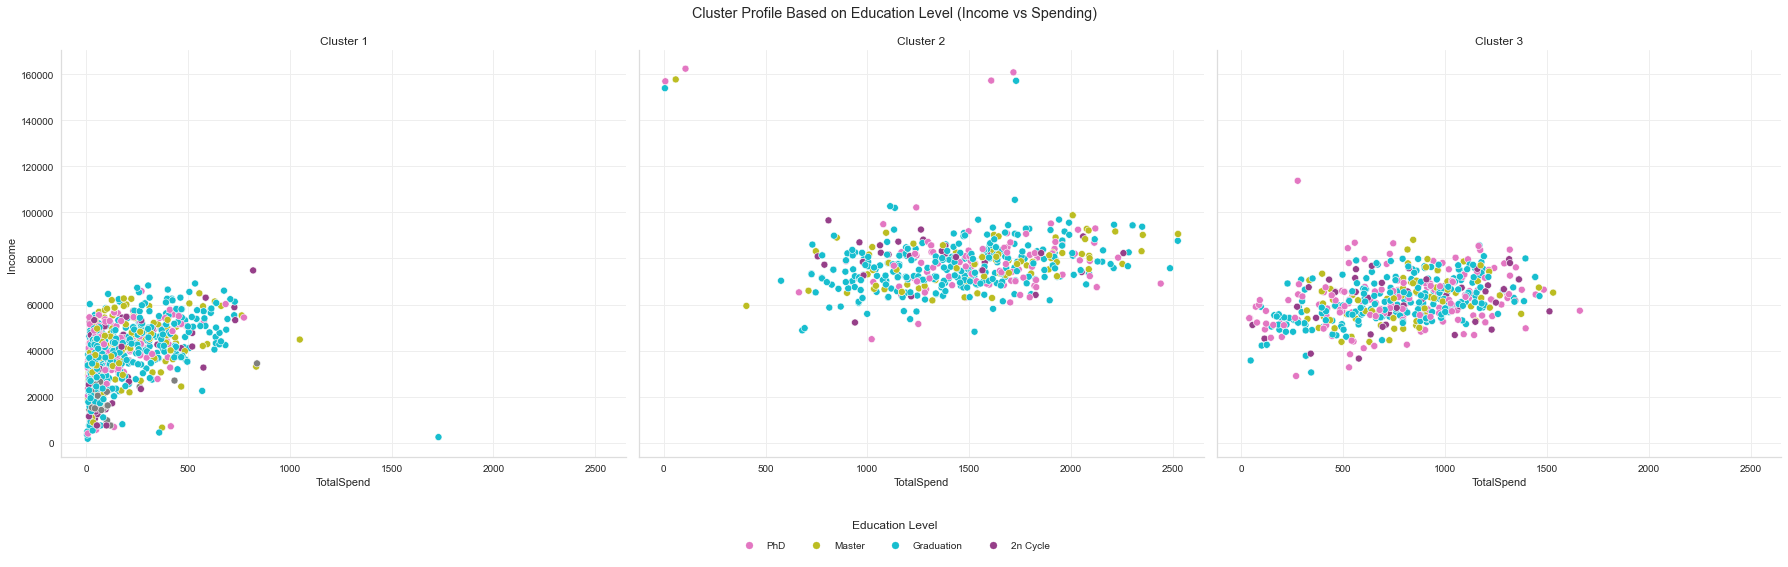

In [27]:
plot_cluster_profile('Minorhome', minor_palette, 'Minors at Home')
plot_cluster_profile('AgeRange', age_palette, 'Age Group')
plot_cluster_profile('Education', education_palette, 'Education Level')

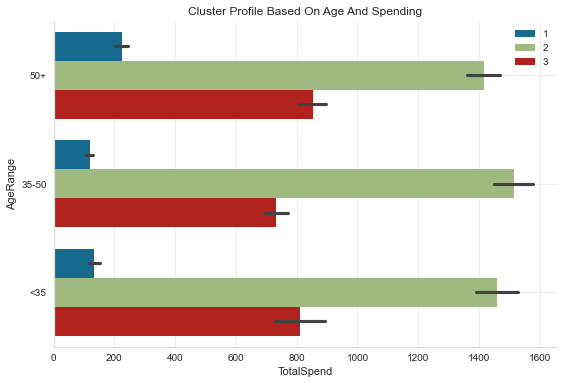

In [28]:
ax = sns.barplot(data=df_orig, x='TotalSpend', y='AgeRange', hue='Cluster')
format_axes(ax)
ax.set_title("Cluster Profile Based On Age And Spending")
plt.legend()
plt.tight_layout()
plt.show()

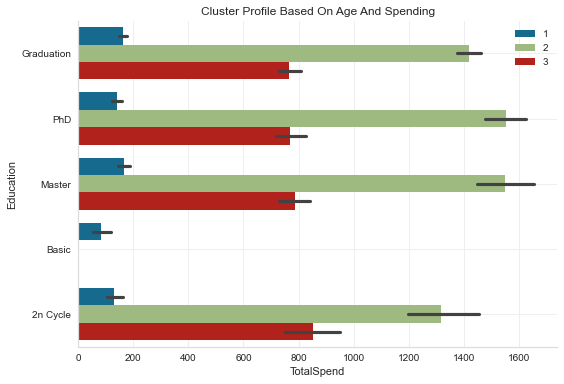

In [29]:
ax = sns.barplot(data=df_orig, x='TotalSpend', y='Education', hue='Cluster')
format_axes(ax)
ax.set_title("Cluster Profile Based On Age And Spending")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
df_orig.head()

,AgeRange,Education,Rel_Status,Income,Minorhome,TotalSpend,Cluster
0,50+,Graduation,Single,58138.0,No,1617,2
1,50+,Graduation,Single,46344.0,Yes,27,1
2,35-50,Graduation,Coupled,71613.0,No,776,2
3,<35,Graduation,Coupled,26646.0,Yes,53,1
4,<35,PhD,Coupled,58293.0,Yes,422,3


In [31]:
plot_df = df_orig.copy()
plot_df.head()

,AgeRange,Education,Rel_Status,Income,Minorhome,TotalSpend,Cluster
0,50+,Graduation,Single,58138.0,No,1617,2
1,50+,Graduation,Single,46344.0,Yes,27,1
2,35-50,Graduation,Coupled,71613.0,No,776,2
3,<35,Graduation,Coupled,26646.0,Yes,53,1
4,<35,PhD,Coupled,58293.0,Yes,422,3


In [32]:
plot_df['Education'].value_counts()

Graduation    1115
PhD            480
Master         365
2n Cycle       198
Basic           54
Name: Education, dtype: int64

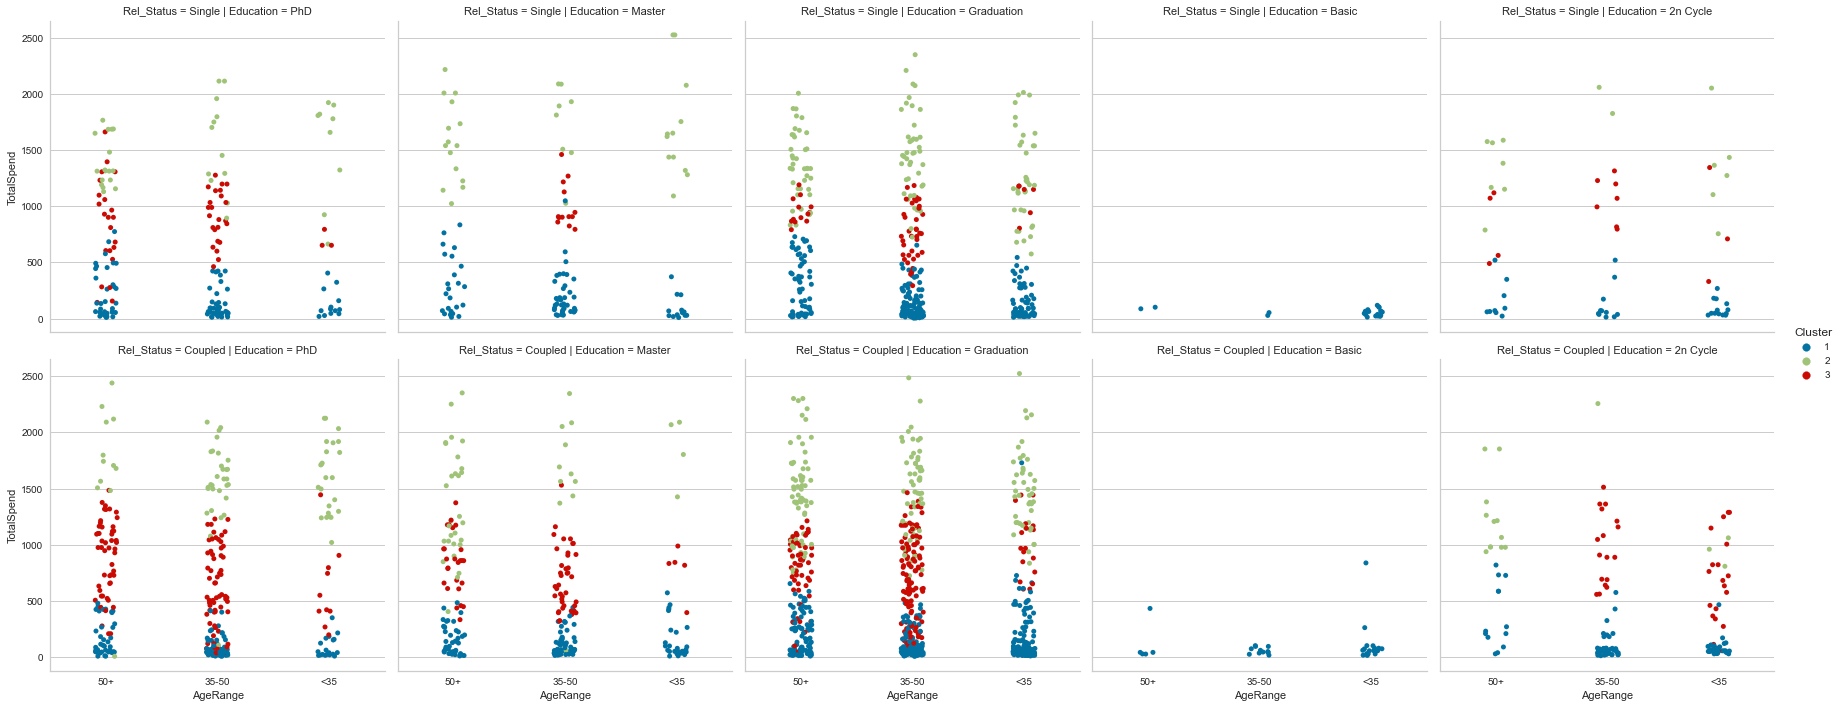

In [33]:
col_order = ['PhD', 'Master', 'Graduation', 'Basic', '2n Cycle']
# custom_palette = sns.color_palette(palette=[ '#fb8a89', '#a6cee3', '#3f6284', '#a7b170', '#66a61e'])
ax = sns.catplot(data=plot_df, kind='strip', x='AgeRange', y='TotalSpend', row='Rel_Status', col='Education', col_order=col_order, hue='Cluster')


From the plots above, we can observe that people with higher income are likely to spend more on our products which is intuitively appropriate.
Customers with spouses are likely to spend more. This could be due to purchases for the family.
Most of our customers are graduates, followed by people holding PhD degrees. A significant cluster is also formed by people with Education listed as "2n Cycle". These are degrees equivalent to 2-year Masters' education, usually prominent in European countries like Italy and Poland. This hints at the fact that quite a few of our customers are internationals.
